# Long-Short Equity Strategies


We've covered some ways to generate trading signals in the previous notebooks. We'll discuss a way to convert those signals into a trading strategy in this notebook.

Long-short equity strategy is both long and short in the equity market. The strategy rank all stocks in the market using some model. The strategy then goes long (buys) the top $n$ equities of the ranking, and goes short on (sells) the bottom $n$ while maintaining equal dollar volume between the long and short positions. 

This has the advantage of being statistically robust, as by ranking stocks and entering hundreds or thousands of positions, you are making many bets on your ranking model rather than just a few risky bets. You are also betting purely on the quality of your ranking scheme, as the equal dollar volume long and short positions ensure that the strategy will remain market neutral (immune to market movements).

## Ranking Scheme

A ranking scheme is any model that can assign each stocks a number, where higher is better or worse. Examples could be value factors, technical indicators, pricing models, or a combination of all of the above. For example, you could use the momentum indicators or z score discussed in a previous notebook to give a ranking to stocks . Another example could be the following

1. Score stocks based on 0.5 x the PE Ratio of that stock + 0.5 x the 30 day price momentum
2. Rank stocks based on that score

Ranking schemes are the secret sauce of any long-short equity strategy, so developing them is nontrivial.

## Making a Bet on the Ranking Scheme

Once we have determined a ranking scheme, we would like to be able to profit from it. We do this by investing an equal amount of money long into the top of the ranking, and short into the bottom. This ensures that the strategy will make money proportionally to the quality of the ranking only, and will be market neutral.

### Long and Short Baskets
Let's say you are ranking $m$ equities, have $d$ dollars to invest, and your total target number of positions to hold is $2n$
* For each equity in spots $1, \dots, n$ in the ranking, sell $\frac{1}{2n} * d$ dollars of that equity
* For each equity in spots $m - n, \dots, m$ in the ranking, buy $\frac{1}{2n} * d$ dollars of that equity. 
**Note: Friction Because of Prices**
Because equity prices will not always divide $\frac{1}{2n} * d$ evenly, and equities must be bought in integer amounts, there will be some imprecision and the algorithm should get as close as it can to this number. Most algorithms will have access to some leverage during execution, so it is fine to buy slightly more than $\frac{1}{2n} * d$ dollars per equity. This does, however, cause some friction at low capital amounts. For a strategy running $d = 100000$, and $n = 500$, we see that 
$$\frac{1}{2n} * d = \frac{1}{1000} * 100000 = 100$$
This will cause big problems for expensive equities, and cause the algorithm to be overlevered. This is alleviated by trading fewer equities or increasing the capital, $d$.

### Returns Come From The Ranking Spread

The returns of a long-short equity strategy are dependent on how well the ranking spreads out the high and low returns. 
First let's start with a hypothetical example.

### Hypothetical Example
We generate random equite names and a random factor on which to rank them. We also assume our future returns are dependent on these factor values.

In [40]:
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
import scipy.spatial.distance as distance
import scipy
from statsmodels import regression
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import auquanToolbox.dataloader as dl

In [15]:
# We'll generate a random factor
current_factor_values = np.random.normal(0, 1, 10000)
equity_names = ['Equity ' + str(x) for x in range(10000)]

# Now let's say our future returns are dependent on our factor values
future_returns = current_factor_values + np.random.normal(0, 1, 10000)

# Put both the factor values and returns into one dataframe
data = pd.DataFrame(index = equity_names, columns=['Factor Value','Returns'])
data['Factor Value'] = current_factor_values
data['Returns'] = future_returns
# Take a look
data.head(10)

,Factor Value,Returns
Equity 0,-0.088250,2.161104
Equity 1,-0.659453,-1.856399
Equity 2,1.018263,1.379308
Equity 3,1.195174,2.351086
Equity 4,-1.361613,-0.897433
Equity 5,-1.328223,-0.951215
Equity 6,0.882669,0.630814
Equity 7,1.597696,3.242234
Equity 8,2.275312,1.768836
Equity 9,1.180364,3.320480


Now that we have factor values and returns, we can see what would happen if we ranked our equities based on factor values, and then entered the long and short positions.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


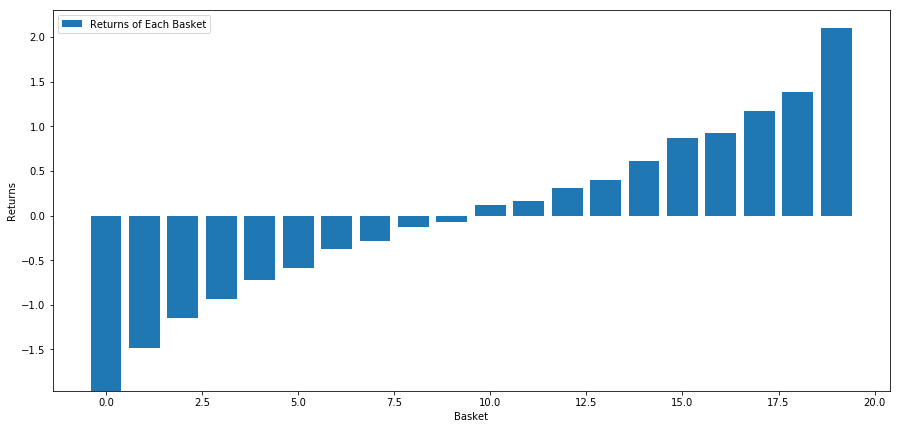

In [16]:
# Rank the equities
ranked_data = data.sort('Factor Value')

# Compute the returns of each basket
# Baskets of size 500, so we create an empty array of shape (10000/500)
number_of_baskets = 10000/500
basket_returns = np.zeros(number_of_baskets)

for i in range(number_of_baskets):
    start = i * 500
    end = i * 500 + 500 
    basket_returns[i] = ranked_data[start:end]['Returns'].mean()

# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

Let's compute the returns if we go long the top basket and short the bottom basket.

In [17]:
basket_returns[number_of_baskets-1] - basket_returns[0]

4.0594481454873801

**The nice thing about making money based on the spread of the ranking is that it is unaffected by what the market does.**

Let's now consider a real world example. We will use price based indicators that we have learned so far for ranking. 


In [110]:
# Fetch prices data for 80 stocks from different sectors and plot prices
start = '2012-01-01'
end = '2016-12-31'
assets = ['CMCSA','VZ','T','EA','CVS','KR','PG','PEP','KO','WMT','LOW','DHI','MCD','DIS','HD','BBY','PHM','TGT','M','GPS',
          'SPLS','FOXA','TWX','JCP','EOG','SWN','VLO','SLB','HAL','XOM','COP','WMB','CHK','NBR','GS','USB','WFC','AXP','MET',
          'JPM','HST','BK','HBAN','MS','KEY','RF','FITB','C','JNJ','AMGN','ABT','LLY','BMY','MRK','UNP','CAT','LUV','NEM','DOW',
          'FCX','DD','X','AKS','ARNC','NVDA','ADBE','SYMC','YHOO','EBAY','BSX','QCOM','TXN','AMAT','GLW','HPQ','JNPR','AMD',]
data = dl.load_data_nologs('nasdaq', assets, start, end)
prices = data['ADJ CLOSE']

#Calculate Moving Average Crossover Ribbons for each
rolling_means = {}
for a in assets:
    rolling_means[a]= pd.DataFrame(columns=np.linspace(10, 100, 10))
    
for i in np.linspace(10, 100, 10):
    X = prices.rolling(window=int(i),center=False).mean()
    for a in assets:
        rolling_means[a][i] = X[a].dropna().resample('M').last() # use last instance in month to aggregate

#Calculate a score for each security based on the ribbon
mscores = pd.DataFrame(index=rolling_means[a].index,columns=assets)
for a in assets:
    for date in rolling_means[a].index:
        mavg_values = rolling_means[a].loc[date]
        ranking = stats.rankdata(mavg_values.values)
        d = distance.hamming(ranking, range(1, 11))
        mscores[a].loc[date] = d

# Calculate Monthly returns
returns = prices.resample('M').last()
monthly_returns = returns/returns.shift(-1) -1

Reading CMCSA
Reading VZ
Reading T
Reading EA
Reading CVS
Reading KR
Reading PG
Reading PEP
Reading KO
Reading WMT
Reading LOW
Reading DHI
Reading MCD
Reading DIS
Reading HD
Reading BBY
Reading PHM
Reading TGT
Reading M
Reading GPS
Reading SPLS
Reading FOXA
Reading TWX
Reading JCP
Reading EOG
Reading SWN
Reading VLO
Reading SLB
Reading HAL
Reading XOM
Reading COP
Reading WMB
Reading CHK
Reading NBR
Reading GS
Reading USB
Reading WFC
Reading AXP
Reading MET
Reading JPM
Reading HST
Reading BK
Reading HBAN
Reading MS
Reading KEY
Reading RF
Reading FITB
Reading C
Reading JNJ
Reading AMGN
Reading ABT
Reading LLY
Reading BMY
Reading MRK
Reading UNP
Reading CAT
Reading LUV
Reading NEM
Reading DOW
Reading FCX
Reading DD
Reading X
Reading AKS
Reading ARNC
Reading NVDA
Reading ADBE
Reading SYMC
Reading YHOO
Reading EBAY
Reading BSX
Reading QCOM
Reading TXN
Reading AMAT
Reading GLW
Reading HPQ
Reading JNPR
Reading AMD


## Looking at Correlations Over Time

Now that we have the data, let's do something with it. Our first analysis will be to measure the monthly Spearman rank correlation coefficient between Momentum score and month-forward returns. In other words, how predictive of 30-day returns is ranking your universe by momentum.

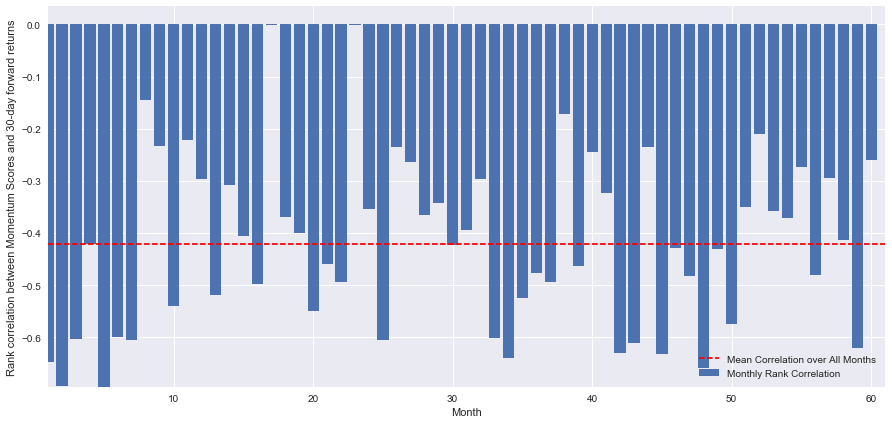

In [111]:
l = mscores.index.size
scores = np.zeros(l)
pvalues = np.zeros(l)
for i in range(l):
    score, pvalue = stats.spearmanr(mscores.iloc[i], monthly_returns.iloc[i])
    pvalues[i] = pvalue
    scores[i] = score
    
plt.figure(figsize=(15,7))
plt.bar(range(1,l+1),scores)
plt.hlines(np.mean(scores), 1,l+1, colors='r', linestyles='dashed')
plt.xlabel('Month')
plt.xlim((1, l+1))
plt.legend(['Mean Correlation over All Months', 'Monthly Rank Correlation'])
plt.ylabel('Rank correlation between Momentum Scores and 30-day forward returns');
plt.show()

We can see that the average correlation is negative, but varies a lot from month to month. It's important to note that this monthly and between 2012 and 2016

## Basket Returns

The next step is to compute the returns of baskets taken out of our ranking. If we rank all equities and then split them into $n$ groups, what would the mean return be of each group? We can answer this question in the following way. The first step is to create a function that will give us the mean return in each basket in a given the month and a ranking factor.

In [112]:
def compute_basket_returns(factor_data, forward_returns, number_of_baskets, month):

    data = pd.concat([factor_data.iloc[month-1],forward_returns.iloc[month-1]], axis=1)
    # Rank the equities on the factor values
    data.columns = ['Factor Value', 'Month Forward Returns']
    data.sort('Factor Value', inplace=True)
    # How many equities per basket
    equities_per_basket = np.floor(len(data.index) / number_of_baskets)

    basket_returns = np.zeros(number_of_baskets)

    # Compute the returns of each basket
    for i in range(number_of_baskets):
        start = i * equities_per_basket
        if i == number_of_baskets - 1:
            # Handle having a few extra in the last basket when our number of equities doesn't divide well
            end = len(data.index) - 1
        else:
            end = i * equities_per_basket + equities_per_basket
        # Actually compute the mean returns for each basket
        #s = data.index.iloc[start]
        #e = data.index.iloc[end]
        basket_returns[i] = data.iloc[int(start):int(end)]['Month Forward Returns'].mean()
        
    return basket_returns


#### Average Basket Return

We first compute this for each month and then average. This should give us a sense of the relationship over a long timeframe.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


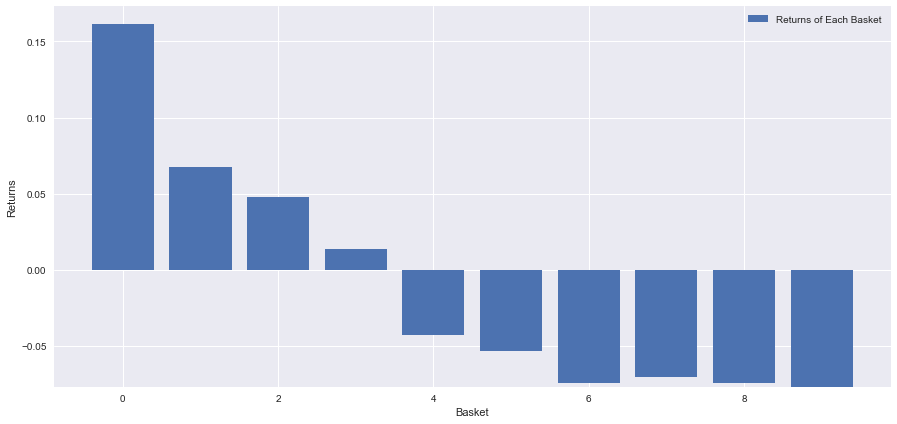

In [116]:
number_of_baskets = 10
mean_basket_returns = np.zeros(number_of_baskets)
for m in range(1, l+1):
    basket_returns = compute_basket_returns(mscores, monthly_returns, number_of_baskets, m)
    mean_basket_returns += basket_returns

mean_basket_returns /= 24    

# Plot the returns of each basket
plt.figure(figsize=(15,7))
plt.bar(range(number_of_baskets), mean_basket_returns)
plt.ylabel('Returns')
plt.xlabel('Basket')
plt.legend(['Returns of Each Basket'])
plt.show()

### Spread Consistency

Of course, that's just the average relationship. To get a sense of how consistent this is, and whether or not we would want to trade on it, we should look at it over time. Here we'll look at the monthly spreads for the first 18 months. We can see a lot of variation, and further analysis should be done to determine whether this momentum score is tradeable.

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


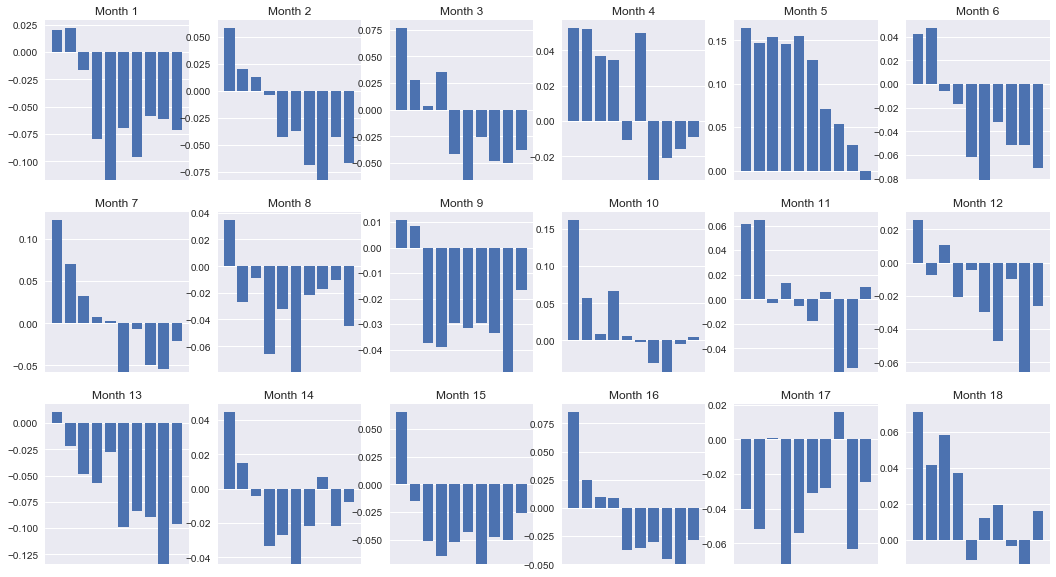

In [123]:

f, axarr = plt.subplots(3, 6,figsize=(18, 10))
for month in range(1, 19):
    basket_returns = compute_basket_returns(mscores, monthly_returns, number_of_baskets, month)
    r = int(np.floor((month-1) / 6))
    c = (month-1) % 6
    axarr[r, c].bar(range(number_of_baskets), basket_returns)
    axarr[r, c].xaxis.set_visible(False) # Hide the axis lables so the plots aren't super messy
    axarr[r, c].set_title('Month ' + str(month))
plt.show()

Finally, lets look at the returns if we had bought the first basket and sold the last basket every month (assuming equal capital allocation to each security)

In [133]:
number_of_baskets = 10
strategy_returns = np.zeros(l)
for m in range(1, l+1):
    basket_returns = compute_basket_returns(mscores, monthly_returns, number_of_baskets, m)
    strategy_returns[m-1] = basket_returns[0]-basket_returns[ number_of_baskets-1]

print('Total Returns: %.2f%%'%strategy_returns.sum())

C:\Users\Chandini\Miniconda3\envs\auquan\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


Total Returns: 5.71%


## Long-Short is a Modular Strategy

To execute a long-short equity, you effectively only have to determine the ranking scheme. Everything after that is mechanical. Once you have one long-short equity strategy, you can swap in different ranking schemes and leave everything else in place. It's a very convenient way to quickly iterate over ideas you have without having to worry about tweaking code every time.

The ranking schemes can come from pretty much any model as well. It doesn't have to be a value based factor model, it could be a machine learning technique that predicted returns one-month ahead and ranked based on that.


## Choice and Evaluation of a Ranking Scheme

The ranking scheme is where a long-short equity strategy gets its edge, and is the most crucial component. Choosing a good ranking scheme is the entire trick, and there is no easy answer. A good starting point is to pick existing known techniques, and see if you can modify them slightly to get increased returns. We'll discuss a few starting points here.

* ### Clone and Tweak
Choose one that is commonly discussed and see if you can modify it slightly to gain back an edge. Often times factors that are public will have no signal left as they have been completely arbitraged out of the market. However, sometimes they lead you in the right direction of where to go.

* ### Pricing Models
Any model that predicts future returns can be a factor. The future return predicted is now that factor, and can be used to rank your universe. You can take any complicated pricing model and transform it into a ranking.

* ### Price Based Factors (Technical Indicators)
Price based factors take information about the historical price of each equity and use it to generate the factor value. Examples could be 30-day momentum, or volatility measures.
#### Reversion vs. Momentum
It's important to note that some factors bet that prices, once moving in a direction, will continue to do so. Some factors bet the opposite. Both are valid models on different time horizons and assets, and it's important to investigate whether the underlying behavior is momentum or reversion based.

* ### Fundamental Factors (Value Based)
This is using combinations of fundamental values as we discussed today. Fundamental values contain information that is tied to real world facts about a company, so in many ways can be more robust than prices.

* ### The Arms Race
Ultimately, developing predictive factors is an arms race in which you are trying to stay one step ahead. Factors get arbitraged out of markets and have a lifespan, so it's important that you are constantly doing work to determine how much decay your factors are experiencing, and what new factors might be used to take their place.


## Additional Considerations

### Rebalancing Frequency

Every ranking system will be predictive of returns over a slightly different timeframe. A price-based mean reversion may be predictive over a few days, while a value-based factor model may be predictive over many months. It is important to determine the timeframe over which your model should be predictive, and statistically verify that before executing your strategy. You do want to overfit by trying to optimize the relabancing frequency, you will inevitably find one that is randomly better than others, but not necessary because of anything in your model.

Once you have determined the timeframe on which your ranking scheme is predictive, try to rebalance at about that frequency so you're taking full advantage of your models.


### Capital Capacity and Transaction Costs

Every strategy has a minimum and maximum amount of capital it can trade before it stops being profitable.


Trading many equities will result in high transaction costs. Say that you want to purchase $1000$ equities, you will incur thousands of dollars of costs per rebalance. Your capital base must be high enough that the transaction costs are a small percentage of the returns being generated by your strategy. Say that you are running $100,000$ dollars and making $1\%$ per month, then the $1000$ dollars of transaction fees per month would take up your all of returns. You would need to be running the strategy on millions of dollars for it to be profitable over $1000$ equities.

The minimum capacity is quite high as such, and dependent largely on the number of equities traded. However, the maximum capacity is also incredibly high, with long-short equity strategies capable of trading hundreds of millions of dollars without losing their edge. This is true because the strategy rebalances relatively infrequently, and the total dollar volume is divided by the number of equities traded. So if you turn over your entire portfolio of $100,000,000$ every month while running 1000 equities, you are only running $100,000$ dollar-volume per month through each equity, which isn't enough to be a significant market share for most securities.